In [142]:
import wrds
import pandas as pd
import numpy as np
import os
import datetime
import time
import matplotlib.pyplot as plt
import seaborn as sns

# Get the current working directory
script_dir = os.getcwd()

# Set the working directory to the current script's directory (which in this case is already the working directory)
os.chdir(script_dir)

print(f"Working directory is set to: {script_dir}")

Working directory is set to: /Users/zrsong/MIT Dropbox/Zirui Song/Research Projects/Direct Lending/Code


# Clean Extracted Loans (Tranche_Level) from March 1st Extraction

In [143]:
extracted_loans = pd.read_csv("../Data/Raw/loan_extraction_update_250301.csv")

In [144]:
# Drop rows where any column between lender_name and maturity_months is missing
filtered_loans = extracted_loans.dropna(subset=[
    'lender_name', 
    'borrower_name', 
    'multiple_facilities',
    'facility_type',
    'facility_active_date',
    'facility_maturity_date',
    'facility_amount',
    'maturity_months',
    'secured',
    'interest_rate',
    'lead_arranger',
])

# Print the shape before and after filtering
print(f"Original shape: {extracted_loans.shape}")
print(f"After dropping missing values: {filtered_loans.shape}")

# Show a sample of the filtered data
filtered_loans.head()

Original shape: (18491, 31)
After dropping missing values: (13641, 31)


,accession,filename,type_filing,type_attachment,date,form_type,loan,amendment,targeted_scope,reasoning,...,lowest_rate,highest_rate,monthly_fs,projected_fs,lender_meeting,gvkey,CIK,lead_arranger,standardized_lead_arranger,lcoid
0,0000950116-96-000036,0000950116-96-000036_0007.txt,10-K405,EX-10.(AB),1996-01-29,10-K405,1,0,0,The lender is identified as 'First Fidelity Ba...,...,LIBOR + 2%,LIBOR + 5%,0,0,0,11904.0,766041,First Fidelity Bank,First Fidelity Bank,NaN
1,0000950116-96-000036,0000950116-96-000036_0007.txt,10-K405,EX-10.(AB),1996-01-29,10-K405,1,0,0,The lender is identified as 'First Fidelity Ba...,...,LIBOR + 2%,LIBOR + 5%,0,0,0,11904.0,766041,First Fidelity Bank,First Fidelity Bank,NaN
2,0000077543-96-000003,0000077543-96-000003_0001.txt,10-K,EX-10,1996-03-27,10-K,1,0,0,The contract outlines a bridge credit agreemen...,...,LIBOR + 2%,LIBOR + 2%,0,0,0,8486.0,77543,Morgan Guaranty Trust Company of New York,Morgan Guaranty Trust,6031.0
4,0000950152-97-008892,0000950152-97-008892_0002.txt,8-K,EX-10.1,1997-12-30,8-K,1,0,0,The contract outlines a credit agreement betwe...,...,NaN,NaN,0,0,0,16747.0,215403,"Strategic Acquisition Partners, LLC","Strategic Acquisition Partners, LLC",NaN
9,0001047469-99-030604,0001047469-99-030604_0001.txt,10-Q,EX-10.1,1999-08-10,10-Q,1,0,0,The loan agreement primarily identifies the Ca...,...,NaN,NaN,0,0,0,148317.0,1042465,California Infrastructure and Economic Develop...,California Infrastructure and Economic Develop...,NaN


Summary statistics for interest rates:
count    11885.000000
mean         3.527421
std          5.320140
min          0.000000
25%          1.250000
50%          2.250000
75%          4.500000
max        100.000000
Name: clean_rate, dtype: float64

Number of loans with interest rates > 20%: 52
Number of loans with interest rates > 50%: 31


/var/folders/n2/pgdf58ms1yd3ch8xjn9fmpmm0000gq/T/ipykernel_2797/2552011422.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_loans.loc[:, 'interest_rate_pct'] = filtered_loans['interest_rate'].apply(extract_interest_rate)
/var/folders/n2/pgdf58ms1yd3ch8xjn9fmpmm0000gq/T/ipykernel_2797/2552011422.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_loans.loc[:, 'lowest_rate_pct'] = filtered_loans['lowest_rate'].apply(extract_interest_rate)
/var/folders/n2/pgdf58ms1yd3ch8xjn9fmpmm0000gq/T

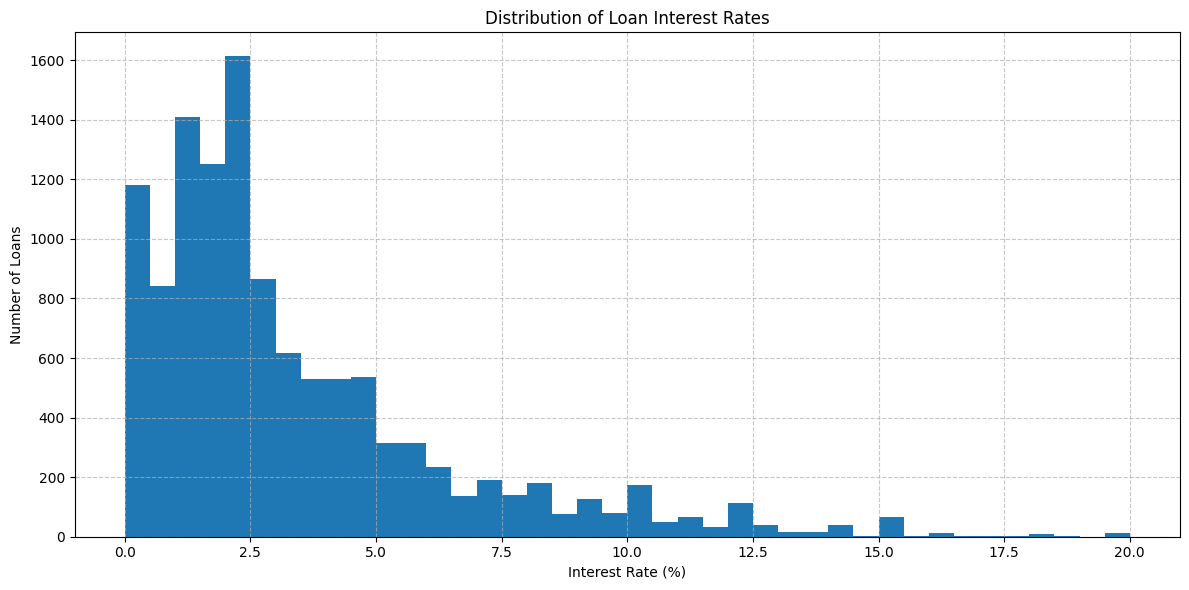

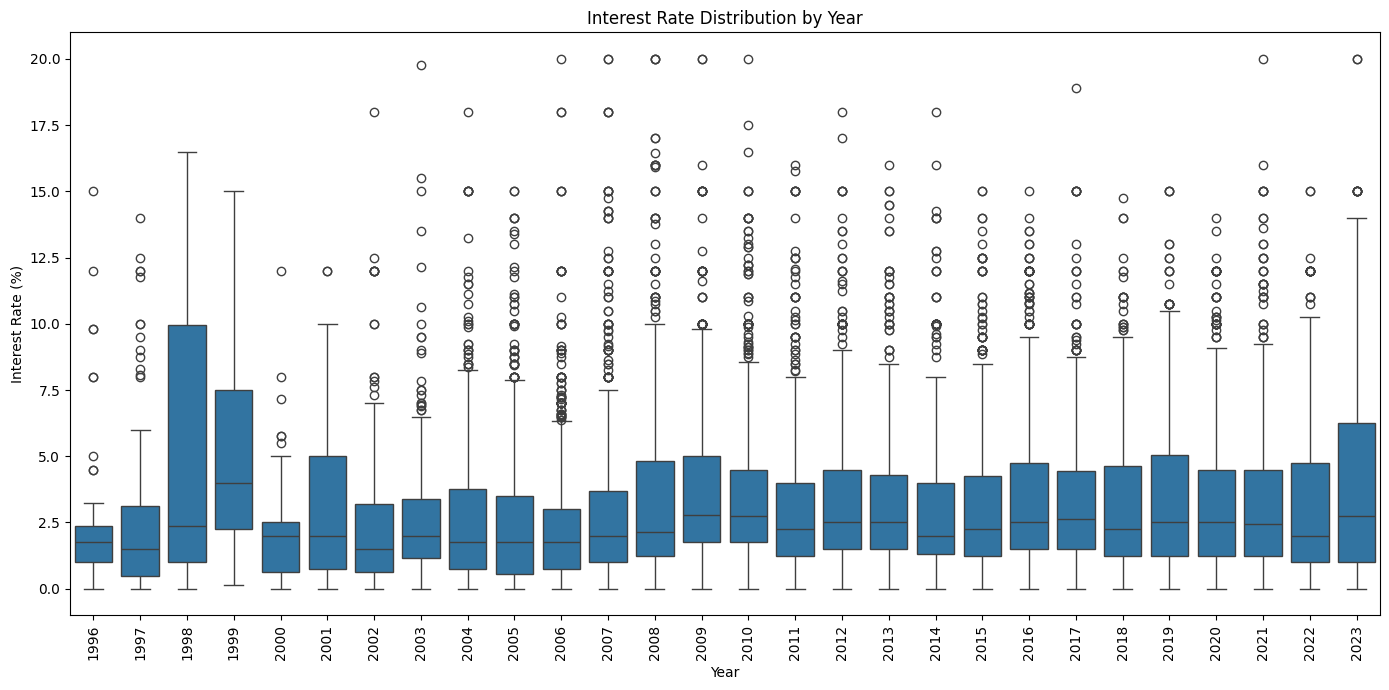

In [145]:
import re

# Define a function to extract numeric interest rates from string
def extract_interest_rate(rate_str):
    if pd.isna(rate_str):
        return np.nan
    
    # Convert to string to handle any non-string inputs
    rate_str = str(rate_str).upper()
    
    # Common patterns in the data
    if 'LIBOR' in rate_str or 'SOFR' in rate_str or 'PRIME' in rate_str:
        # Extract numbers following + or following "to" (for ranges)
        matches = re.findall(r'[+]\s*(\d+\.?\d*)', rate_str)
        if matches:
            return float(matches[0])
        
        # Check for percentage values
        percent_matches = re.findall(r'(\d+\.?\d*)%', rate_str)
        if percent_matches:
            return float(percent_matches[0])
    else:
        # For direct percentage values
        percent_matches = re.findall(r'(\d+\.?\d*)%', rate_str)
        if percent_matches:
            return float(percent_matches[0])
    
    return np.nan

# Apply the function to clean the interest rate columns
filtered_loans.loc[:, 'interest_rate_pct'] = filtered_loans['interest_rate'].apply(extract_interest_rate)
filtered_loans.loc[:, 'lowest_rate_pct'] = filtered_loans['lowest_rate'].apply(extract_interest_rate)
filtered_loans.loc[:, 'highest_rate_pct'] = filtered_loans['highest_rate'].apply(extract_interest_rate)

# Create a combined interest rate column (using lowest when available, otherwise interest_rate)
filtered_loans.loc[:, 'clean_rate'] = filtered_loans['lowest_rate_pct'].fillna(filtered_loans['interest_rate_pct'])

# Check for rates greater than 100 and adjust them
for col in ['interest_rate_pct', 'lowest_rate_pct', 'highest_rate_pct', 'clean_rate']:
    # Create a mask for values > 100
    mask = filtered_loans[col] > 100
    # Apply division only to those values
    filtered_loans.loc[mask, col] = filtered_loans.loc[mask, col] / 100

# Display summary statistics of the clean_rate column
rate_stats = filtered_loans['clean_rate'].describe()
print("Summary statistics for interest rates:")
print(rate_stats)

# Check for extreme values (potentially erroneous)
print("\nNumber of loans with interest rates > 20%:", (filtered_loans['clean_rate'] > 20).sum())
print("Number of loans with interest rates > 50%:", (filtered_loans['clean_rate'] > 50).sum())

# Filter out extreme values (likely data errors)
filtered_loans = filtered_loans[filtered_loans['clean_rate'].isna() | (filtered_loans['clean_rate'] <= 20)]

# Create histogram of interest rates
plt.figure(figsize=(12, 6))
filtered_loans['clean_rate'].hist(bins=40)
plt.title('Distribution of Loan Interest Rates')
plt.xlabel('Interest Rate (%)')
plt.ylabel('Number of Loans')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Convert date to datetime format and extract year (if not already done)
if 'year' not in filtered_loans.columns:
    filtered_loans['year'] = pd.to_datetime(filtered_loans['date']).dt.year

# Plot interest rates over time
plt.figure(figsize=(14, 7))
sns.boxplot(x='year', y='clean_rate', data=filtered_loans)
plt.title('Interest Rate Distribution by Year')
plt.xlabel('Year')
plt.ylabel('Interest Rate (%)')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [149]:

generic_patterns = [
    'lender party', 'lender parties', 'the lender', 
    'lender hereto', 'lenders hereto', 'the lenders',
    'party hereto', 'parties hereto', 'each lender',
    'various lenders'
]

# Convert patterns into a regex pattern
pattern = '|'.join(generic_patterns)

# Replace generic lender descriptions with NaN
filtered_loans.loc[filtered_loans['lead_arranger'].str.contains(pattern, case=False, na=False), 'lead_arranger'] = np.nan
filtered_loans.loc[filtered_loans['standardized_lead_arranger'].str.contains(pattern, case=False, na=False), 'standardized_lead_arranger'] = np.nan

# drop if both lead arranger and standardized lead arranger are missing
filtered_loans = filtered_loans.dropna(subset=['lead_arranger', 'standardized_lead_arranger'], how='all')


         date  year
0  1996-01-29  1996
1  1996-01-29  1996
2  1996-03-27  1996
4  1997-12-30  1997
9  1999-08-10  1999

Number of loans by year:
year
1996     77
1997     87
1998     65
1999     53
2000     53
2001     95
2002    148
2003    257
2004    523
2005    617
2006    724
2007    770
2008    638
2009    441
2010    785
2011    933
2012    670
2013    596
2014    673
2015    679
2016    599
2017    605
2018    545
2019    520
2020    536
2021    736
2022    625
2023    386
Name: count, dtype: int64


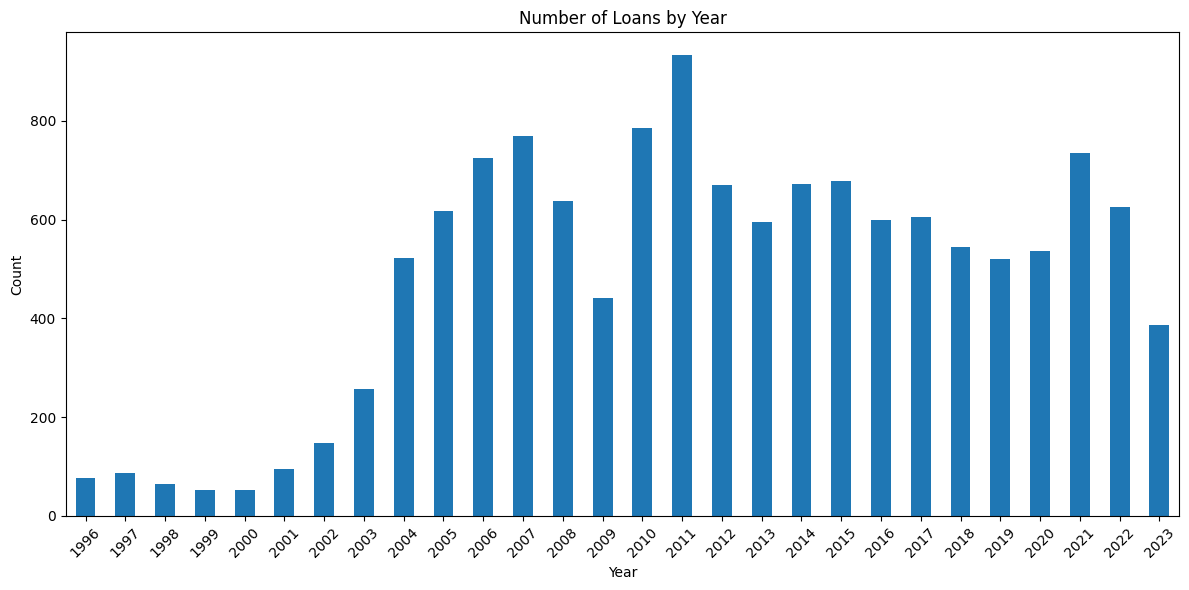

In [150]:
# Convert date to datetime format and extract year
filtered_loans['year'] = pd.to_datetime(filtered_loans['date']).dt.year

# Display the first few rows to verify
print(filtered_loans[['date', 'year']].head())

# Count loans by year
year_counts = filtered_loans['year'].value_counts().sort_index()
print("\nNumber of loans by year:")
print(year_counts)

# Plot the number of loans by year
plt.figure(figsize=(12, 6))
year_counts.plot(kind='bar')
plt.title('Number of Loans by Year')
plt.xlabel('Year')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

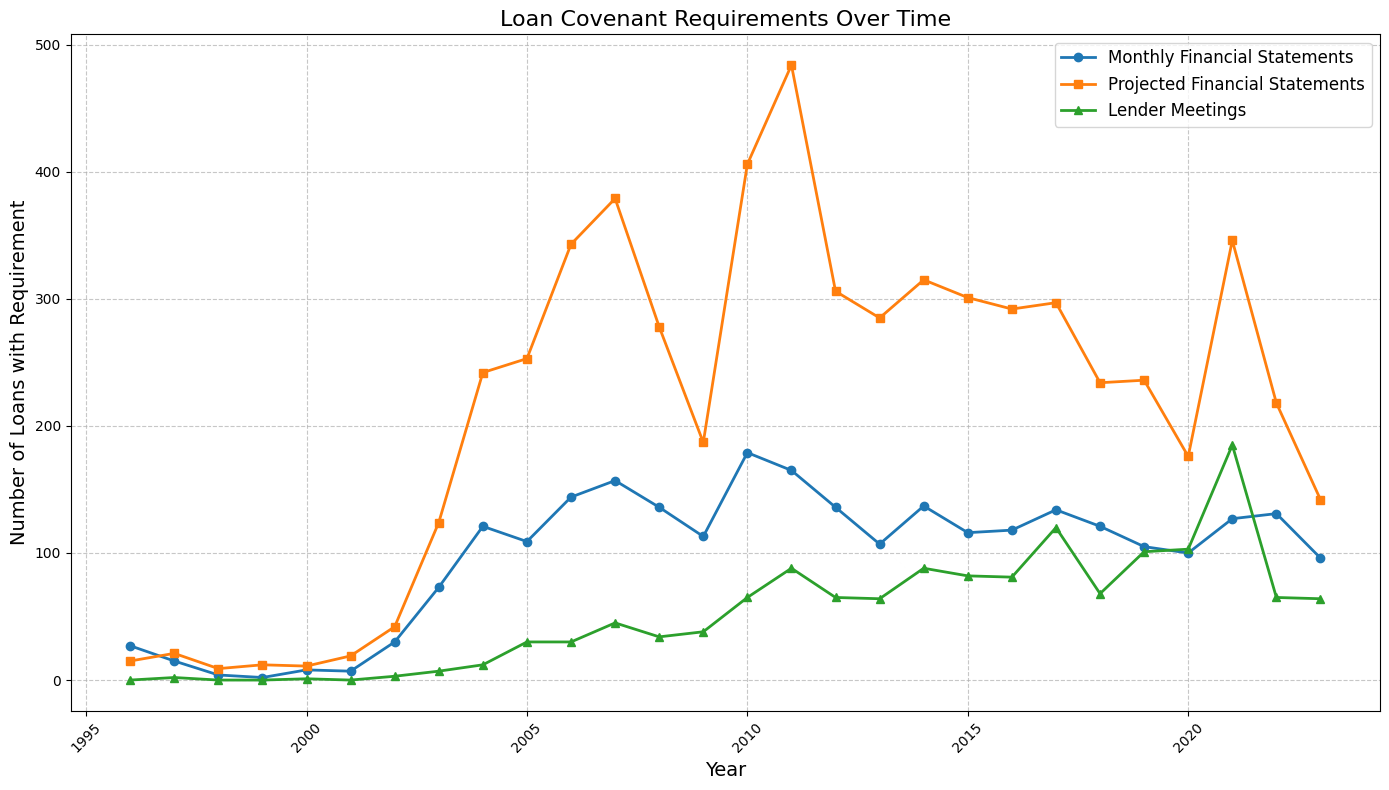

Percentage of loans with each requirement by year:
    Year  Monthly FS (%)  Projected FS (%)  Lender Meeting (%)
0   1996            35.1              19.5                 0.0
1   1997            17.2              24.1                 2.3
2   1998             6.2              13.8                 0.0
3   1999             3.8              22.6                 0.0
4   2000            15.1              20.8                 1.9
5   2001             7.4              20.0                 0.0
6   2002            20.3              28.4                 2.0
7   2003            28.4              48.2                 2.7
8   2004            23.1              46.3                 2.3
9   2005            17.7              41.0                 4.9
10  2006            19.9              47.4                 4.1
11  2007            20.4              49.2                 5.8
12  2008            21.3              43.6                 5.3
13  2009            25.6              42.4                 8.6
14  

In [151]:
# Group by year and count the occurrences where each variable equals 1
monthly_fs_by_year = filtered_loans.groupby('year')['monthly_fs'].sum()
projected_fs_by_year = filtered_loans.groupby('year')['projected_fs'].sum()
lender_meeting_by_year = filtered_loans.groupby('year')['lender_meeting'].sum()

# Create a figure with appropriate size
plt.figure(figsize=(14, 8))

# Plot line charts for each variable
plt.plot(monthly_fs_by_year.index, monthly_fs_by_year.values, marker='o', linewidth=2, label='Monthly Financial Statements')
plt.plot(projected_fs_by_year.index, projected_fs_by_year.values, marker='s', linewidth=2, label='Projected Financial Statements')
plt.plot(lender_meeting_by_year.index, lender_meeting_by_year.values, marker='^', linewidth=2, label='Lender Meetings')

# Add labels and title
plt.title('Loan Covenant Requirements Over Time', fontsize=16)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Number of Loans with Requirement', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)

# Format x-axis to show years with appropriate rotation
plt.xticks(rotation=45)
plt.tight_layout()

# Show the plot
plt.show()

# Calculate and print the percentage of each requirement by year
percentage_df = pd.DataFrame({
    'Year': monthly_fs_by_year.index,
    'Monthly FS (%)': (monthly_fs_by_year / year_counts * 100).values,
    'Projected FS (%)': (projected_fs_by_year / year_counts * 100).values,
    'Lender Meeting (%)': (lender_meeting_by_year / year_counts * 100).values
})

print("Percentage of loans with each requirement by year:")
print(percentage_df.round(1))

In [154]:
# Define bank terms to exclude
bank_terms = ['bank', 'jpmorgan', 'citibank', 'wells fargo', 'morgan stanley', 'credit suisse', 
              'merrill lynch', 'goldman sachs', 'barclays', 'bayerische', 'bbva', 'bear', 'bmo', 
              'bnp paribas', 'bofa', 'capital one', 'cibc', 'citicorp', 'citigroup',
              'citizens', 'credit lyonnais', 'goldman', 'hsbc', 'j.p. morgan', 'j. p. morgan', 
              'jpmorgan', 'jp morgan', 'lehman brothers', 'merrill', 'pnc', 'rbc', 'rbs', 
              'societe generale', 'suntrust', 'toronto dominion', 'ubs', 'société générale', 
              'harris', 'westlb', 'bancorp', 'bancshares', 'bancgroup', 'national association', 'n.a.', 'na',
              'lehman', 'jefferies', 'abn amro', 'barclay', 'cantor fitzgerald']

# Define a list of common private credit terms
private_credit = [
    'ares', 'apollo', 'blackrock', 'blackstone', 'cerberus', 'fortress', 
    'golub', 'kkr', 'oaktree', 'tpg', 'carlyle', 'bain capital', 'antares',
    'private equity', 'private credit', 'venture', 'mezzanine', 'abc', 
    'alter domus', 'athene', 'athyrium', 'bain', 'biopharma', 
    'blue ridge', 'blue torch', 'brookfield', 
    'canada pension plan investment board', 'cap 1 llc', 'carter', 'centre lane', 
    'cf capital llc', 'cf equipment loans', 'cf turul llc', 
    'chambers energy management', 'chatham credit', 'churchill', 'colfin', 
    'comvest', 'cortland capital market', 'cortland products', 'cpp', 'cyan partners', 
    'db realty', 'db structured', 'deerfield', 'eclipse business', 'eig', 'ej funds', 
    'elliott', 'encina', 'enervest', 'enhanced capital', 'ept ski properties',
    'escalate', 'evergreen solar', 'evolve transition', 'fiera private', 'fifth street finance', 
    'five mile capital', 'fleet capital corporation', 'fleet retail', 
    'four winds funding', 'gacp', 'gci capital', 'goldentree', 'gpc partners', 
    'gso', 'guggenheim', 'hercules technology', 'hersha mezz', 'high street capital', 
    'highbridge', 'hps investment', 'hv capital investors', 'inter-americas investment corporation', 
    'whitney mezzanine', 'jcf affm debt', 'jha', 'kayne anderson', 'laminar direct capital', 
    'lasalle business', 'laurus master fund', 'lion capital', 'loan core capital', 'isb funding llc', 
    'macquarie capital', 'madison capital funding', 'madison dearborn', 'mclarity capital', 
    'egg investment group lp', 'mid islandi sf.', 'midcap', 'monroe capital', 'newstar', 
    'northwest farm credit services', 'obsidian', 'orion energy', 'owl rock', 
    'pathlight', 'pdl biopharma', 'patriot capital', 'pepi capital', 'praesidian', 'rhône', 
    'riverstone', 'rock', 'sales capital partners', 'siena lending group', 'silver lake', 'silver point', 
    'sixth street', 'solar capital', 'squadron capital', 'standard general', 'swk', 'tangshan caofeidian', 
    'tc', 'tcf', 'tcw', 'tennenbaum', 'thermo', 'third eye capital corporation', 'thl', 'tpg specialty', 
    'victory park management', 'wynnefield capital', 'z investment', 'sell credit opportunities',
    'plexus', '1903 partners', 'ag energy funding', 'amp capital', 'strategic capital fund', 'agamerica lending',
    'agwest', 'antara', 'mortgage capital', 'bpcr', 'cit northbridge', 'deerpath funding', 'elanus capital',
    'emerald creek', 'full circle capital', 'healthcare royalty partners', 'iep energy', 'inter-american investment',
    'kaynes solution', 'laurel capital', 'macquarie', 'mclarty', 'mgg investment', 'marquette', 'mustang lodging funding',
    'orbimed', 'pcam credit', 'perceptive credit', 'pennymac', 'prudential capital', 'rhi investments', 'red mortgage capital',
    'revere credit', 'salus capital', 'solar senior capital','sts master fund', 'tpc investments'
]

# Create functions to identify lender types
def is_nonbank_lender(lender):
    if pd.isna(lender):
        return 0
    
    lender_lower = str(lender).lower()
    
    # If contains any bank term, it's a bank
    if any(bank_term in lender_lower for bank_term in bank_terms):
        return 0
    
    # Otherwise it's a nonbank
    return 1

def is_private_credit_lender(lender, nonbank=0):
    if pd.isna(lender) or nonbank == 0:
        return 0
    
    lender_lower = str(lender).lower()
    
    # If it's a nonbank and contains any private credit term
    if any(pc_term in lender_lower for pc_term in private_credit):
        return 1
    
    return 0

# Apply the functions to create nonbank_lender flag
filtered_loans['nonbank_lender'] = filtered_loans['lead_arranger'].apply(is_nonbank_lender)

# Check standardized_lead_arranger if available and lead_arranger is classified as bank
mask = (filtered_loans['nonbank_lender'] == 0) & filtered_loans['standardized_lead_arranger'].notna()
filtered_loans.loc[mask, 'nonbank_lender'] = filtered_loans.loc[mask, 'standardized_lead_arranger'].apply(is_nonbank_lender)

# Apply the function to create private_credit_lender flag based on nonbank_lender
filtered_loans['private_credit_lender'] = filtered_loans.apply(
    lambda x: is_private_credit_lender(x['lead_arranger'], x['nonbank_lender']), 
    axis=1
)

# Check standardized_lead_arranger for private credit terms if available and not already identified
mask = (filtered_loans['private_credit_lender'] == 0) & (filtered_loans['nonbank_lender'] == 1) & filtered_loans['standardized_lead_arranger'].notna()
filtered_loans.loc[mask, 'private_credit_lender'] = filtered_loans.loc[mask].apply(
    lambda x: is_private_credit_lender(x['standardized_lead_arranger'], 1),
    axis=1
)

(<Figure size 1400x700 with 1 Axes>,
 {'nonbank_count': 2293,
  'private_credit_count': 521,
  'total_lenders': 13365,
  'nonbank_percentage': 17.15675271230827,
  'private_credit_percentage': 3.898241676019454,
  'nonbank_by_year': year
  1996    14.285714
  1997    24.137931
  1998    24.615385
  1999    26.415094
  2000    28.301887
  2001    16.842105
  2002    16.216216
  2003    14.007782
  2004    13.001912
  2005    15.235008
  2006    18.232044
  2007    14.025974
  2008    15.047022
  2009    19.727891
  2010    11.847134
  2011    11.468382
  2012    15.074627
  2013    18.120805
  2014    13.224368
  2015    17.673049
  2016    19.699499
  2017    17.685950
  2018    15.779817
  2019    21.730769
  2020    23.320896
  2021    20.244565
  2022    22.560000
  2023    25.388601
  Name: nonbank_lender, dtype: float64,
  'private_credit_by_year': year
  1996     0.000000
  1997     2.298851
  1998     1.538462
  1999     0.000000
  2000     1.886792
  2001     0.000000
  2002   

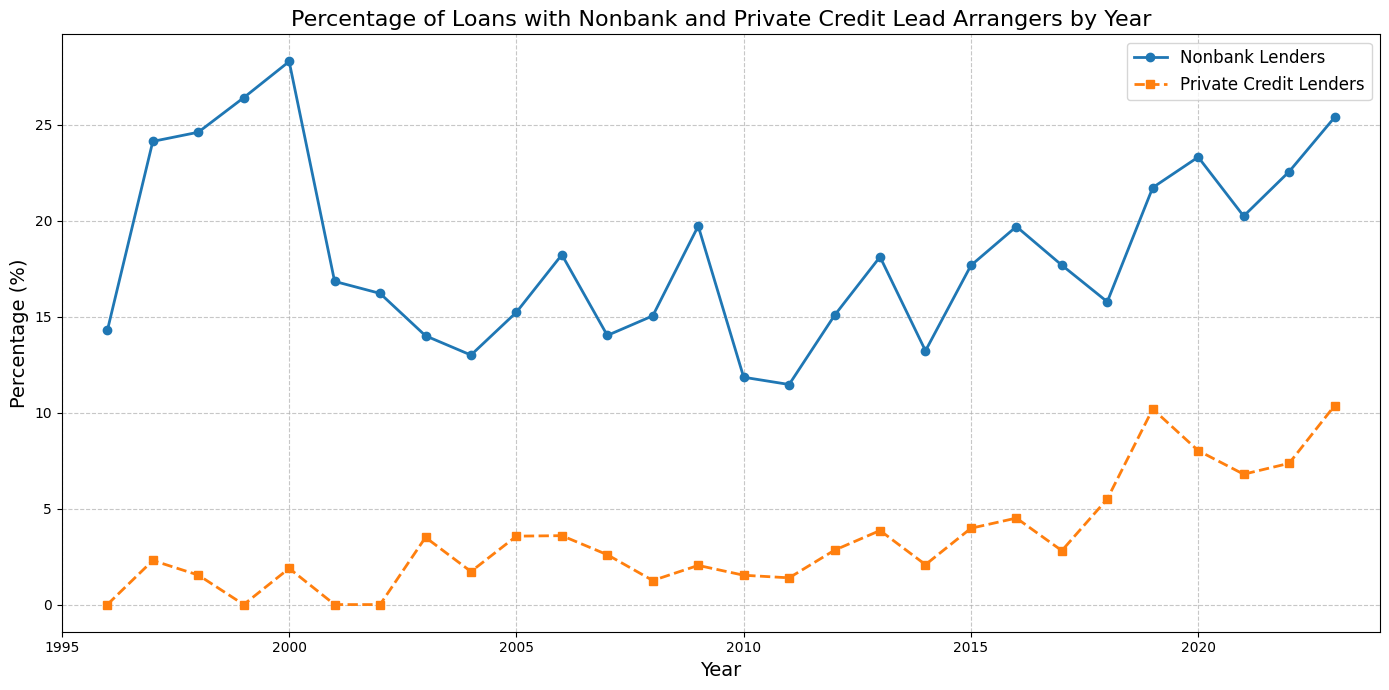

In [155]:
def plot_lender_type_trends(filtered_loans, start_year=1995, end_year=2024, figsize=(14, 7)):
    """
    Plot trends of nonbank and private credit lenders over time.
    
    Parameters:
    -----------
    filtered_loans : DataFrame
        DataFrame containing loan data with lender type information
    start_year : int
        Starting year for the x-axis range
    end_year : int
        Ending year for the x-axis range
    figsize : tuple
        Figure size as (width, height)
    
    Returns:
    --------
    fig : matplotlib Figure
        The figure with the plot
    stats : dict
        Dictionary with summary statistics
    """
    # Check the counts
    nonbank_count = filtered_loans['nonbank_lender'].sum()
    private_credit_count = filtered_loans['private_credit_lender'].sum()
    total_valid_lenders = filtered_loans['lead_arranger'].notna().sum()
    
    # Calculate percentages
    nonbank_pct = nonbank_count / total_valid_lenders * 100
    private_credit_pct = private_credit_count / total_valid_lenders * 100
    
    # Display distribution by year
    nonbank_by_year = filtered_loans.groupby('year')['nonbank_lender'].mean() * 100
    private_credit_by_year = filtered_loans.groupby('year')['private_credit_lender'].mean() * 100
    
    # Create figure for the plot
    fig, ax = plt.subplots(figsize=figsize)
    
    # Plot the trends over time
    ax.plot(nonbank_by_year.index, nonbank_by_year.values, marker='o', linewidth=2, label='Nonbank Lenders')
    ax.plot(private_credit_by_year.index, private_credit_by_year.values, marker='s', linewidth=2, linestyle='--', label='Private Credit Lenders')
    
    # Set labels and title
    ax.set_title('Percentage of Loans with Nonbank and Private Credit Lead Arrangers by Year', fontsize=16)
    ax.set_xlabel('Year', fontsize=14)
    ax.set_ylabel('Percentage (%)', fontsize=14)
    ax.legend(fontsize=12)
    ax.grid(True, linestyle='--', alpha=0.7)
    
    # Set appropriate x-axis range
    ax.set_xlim(start_year, end_year)
    
    # Format plot
    plt.tight_layout()
    
    # Compile statistics to return
    stats = {
        'nonbank_count': nonbank_count,
        'private_credit_count': private_credit_count,
        'total_lenders': total_valid_lenders,
        'nonbank_percentage': nonbank_pct,
        'private_credit_percentage': private_credit_pct,
        'nonbank_by_year': nonbank_by_year,
        'private_credit_by_year': private_credit_by_year
    }
    
    return fig, stats

# Example usage:
# fig, stats = plot_lender_type_trends(filtered_loans)
# plt.show()
# print(f"Overall, {stats['nonbank_percentage']:.1f}% of loans have nonbank lenders")
# print(f"Overall, {stats['private_credit_percentage']:.1f}% of loans have private credit lenders")

# Call the function to see the plot
plot_lender_type_trends(filtered_loans)

(<Figure size 1400x1800 with 3 Axes>,
     Year  Bank Loans  Nonbank Loans  Private Credit Loans  \
 0   1996          66             11                     0   
 1   1997          66             21                     2   
 2   1998          49             16                     1   
 3   1999          39             14                     0   
 4   2000          38             15                     1   
 5   2001          79             16                     0   
 6   2002         124             24                     0   
 7   2003         221             36                     9   
 8   2004         455             68                     9   
 9   2005         523             94                    22   
 10  2006         592            132                    26   
 11  2007         662            108                    20   
 12  2008         542             96                     8   
 13  2009         354             87                     9   
 14  2010         692           

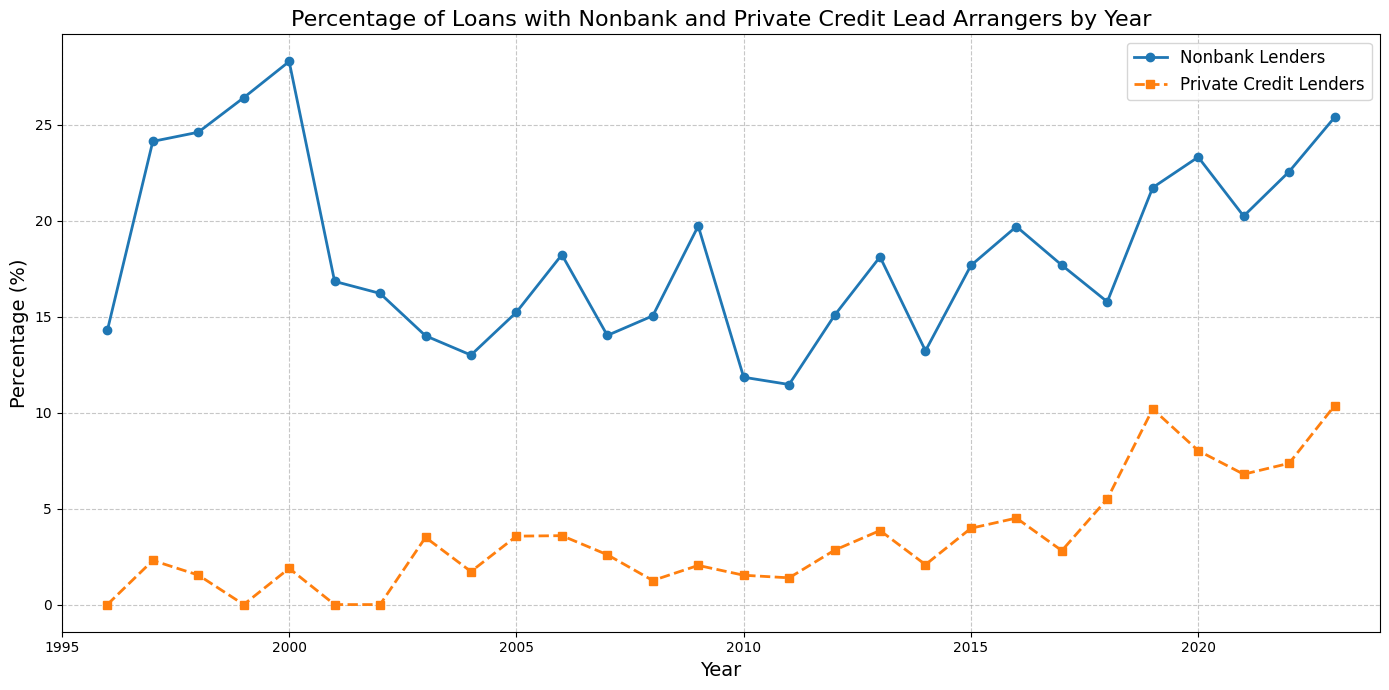

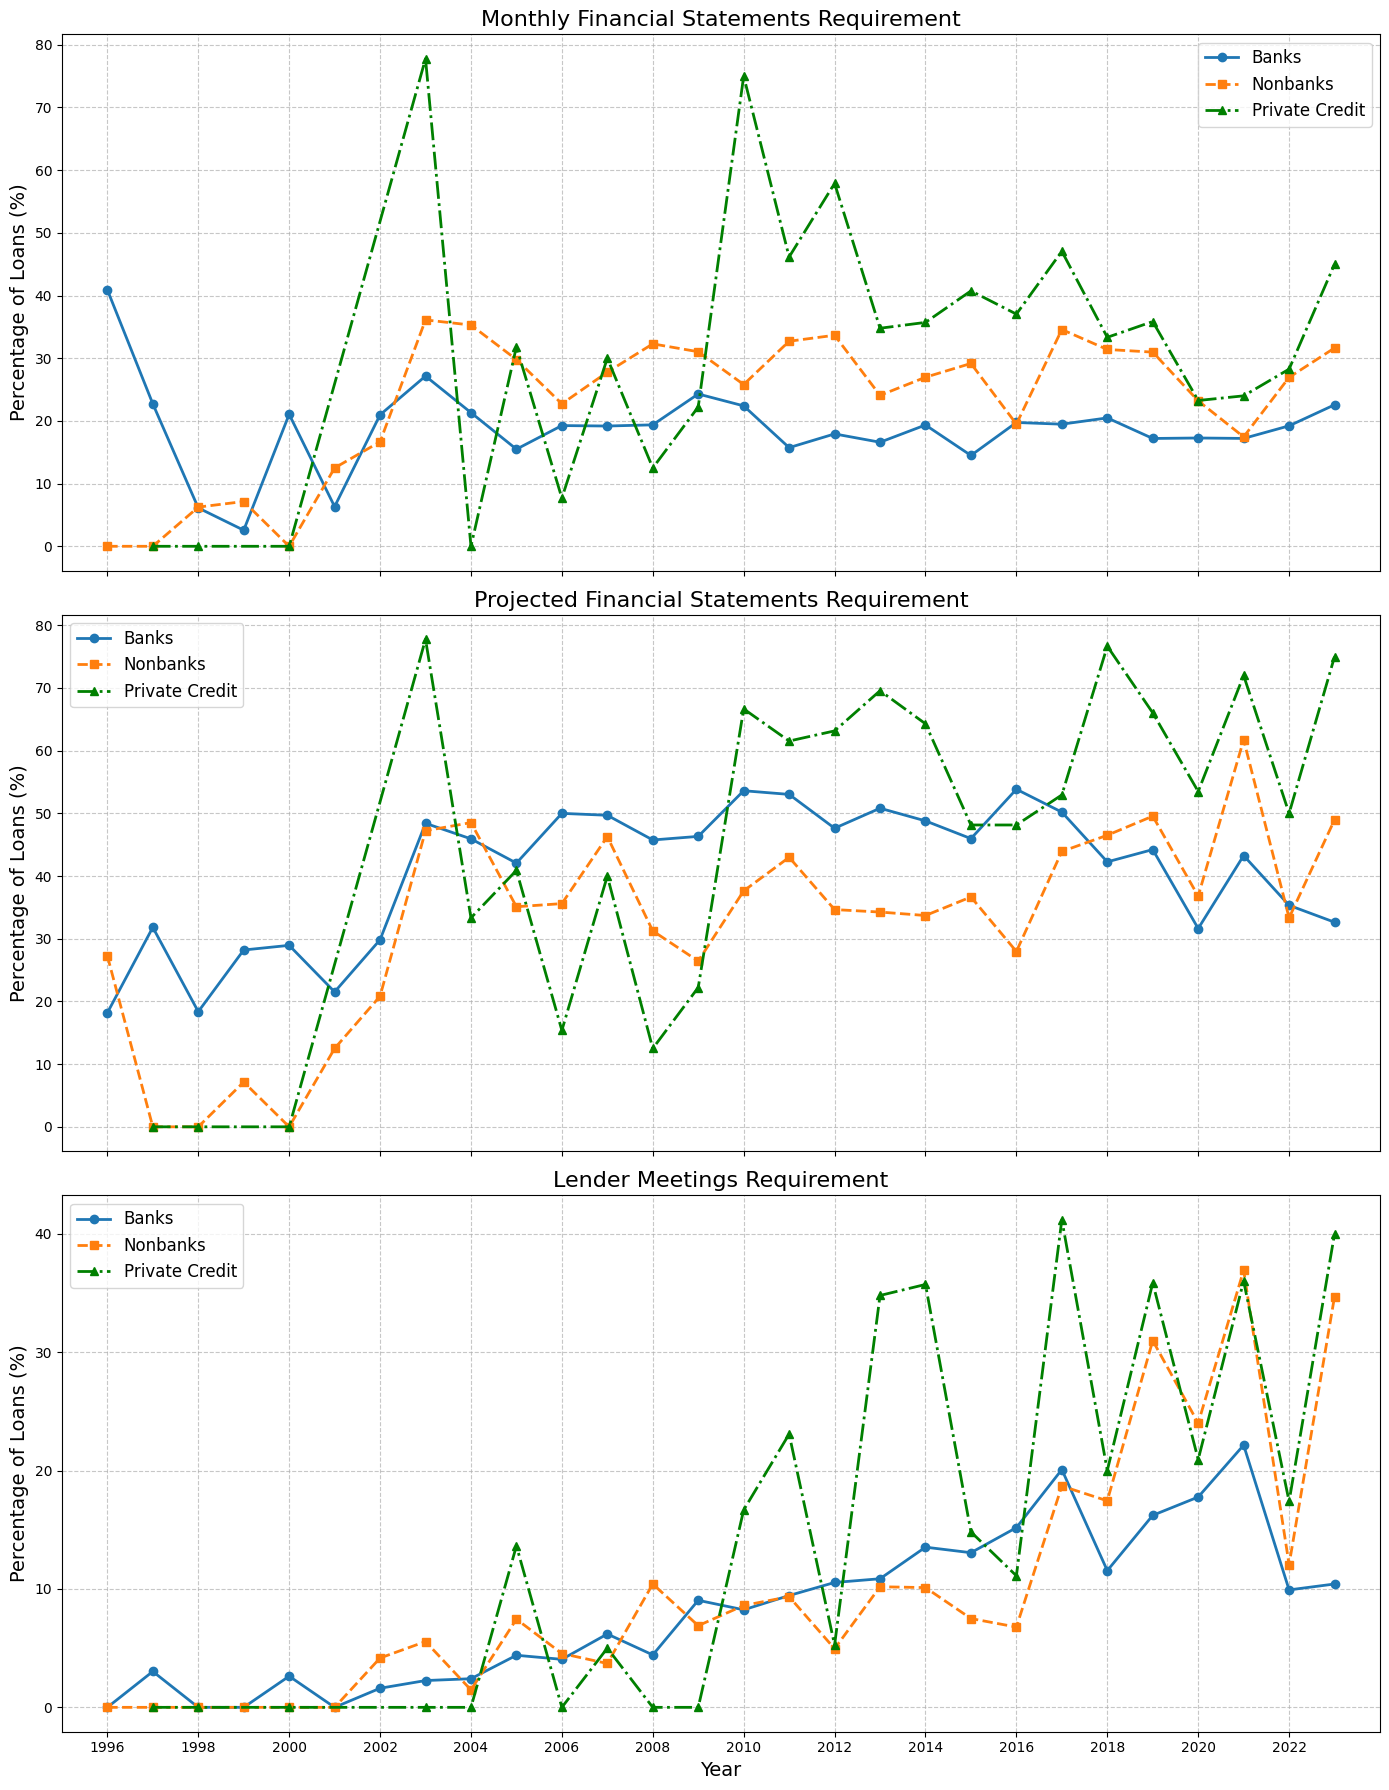

In [156]:
def plot_covenant_requirements_by_lender_type(filtered_loans, start_year=1995, end_year=2024, figsize=(14, 18)):
    """
    Create plots comparing covenant requirements across different types of lenders
    
    Parameters:
    -----------
    filtered_loans : DataFrame
        DataFrame containing loan data with covenant information
    start_year : int
        Starting year for the x-axis range
    end_year : int
        Ending year for the x-axis range
    figsize : tuple
        Figure size as (width, height)
        
    Returns:
    --------
    fig : matplotlib Figure
        The figure with the plots
    summary_df : DataFrame
        Summary dataframe with covenant requirements by lender type
    """
    # Create dataframes for banks, nonbanks, and private credit
    bank_loans = filtered_loans[filtered_loans['nonbank_lender'] == 0]
    nonbank_loans = filtered_loans[filtered_loans['nonbank_lender'] == 1]
    private_credit_loans = filtered_loans[filtered_loans['private_credit_lender'] == 1]

    # Group by year and calculate percentages for banks
    bank_monthly_pct = bank_loans.groupby('year')['monthly_fs'].mean() * 100
    bank_projected_pct = bank_loans.groupby('year')['projected_fs'].mean() * 100
    bank_meeting_pct = bank_loans.groupby('year')['lender_meeting'].mean() * 100

    # Group by year and calculate percentages for nonbanks
    nonbank_monthly_pct = nonbank_loans.groupby('year')['monthly_fs'].mean() * 100
    nonbank_projected_pct = nonbank_loans.groupby('year')['projected_fs'].mean() * 100
    nonbank_meeting_pct = nonbank_loans.groupby('year')['lender_meeting'].mean() * 100

    # Group by year and calculate percentages for private credit
    pc_monthly_pct = private_credit_loans.groupby('year')['monthly_fs'].mean() * 100
    pc_projected_pct = private_credit_loans.groupby('year')['projected_fs'].mean() * 100
    pc_meeting_pct = private_credit_loans.groupby('year')['lender_meeting'].mean() * 100

    # Create a figure with 3 subplots (one for each covenant type)
    fig, axes = plt.subplots(3, 1, figsize=figsize, sharex=True)

    # Plot Monthly Financial Statements
    axes[0].plot(bank_monthly_pct.index, bank_monthly_pct.values, marker='o', linewidth=2, label='Banks')
    axes[0].plot(nonbank_monthly_pct.index, nonbank_monthly_pct.values, marker='s', linewidth=2, linestyle='--', label='Nonbanks')
    axes[0].plot(pc_monthly_pct.index, pc_monthly_pct.values, marker='^', linewidth=2, linestyle='-.', color='green', label='Private Credit')
    axes[0].set_title('Monthly Financial Statements Requirement', fontsize=16)
    axes[0].set_ylabel('Percentage of Loans (%)', fontsize=14)
    axes[0].grid(True, linestyle='--', alpha=0.7)
    axes[0].legend(fontsize=12)

    # Plot Projected Financial Statements
    axes[1].plot(bank_projected_pct.index, bank_projected_pct.values, marker='o', linewidth=2, label='Banks')
    axes[1].plot(nonbank_projected_pct.index, nonbank_projected_pct.values, marker='s', linewidth=2, linestyle='--', label='Nonbanks')
    axes[1].plot(pc_projected_pct.index, pc_projected_pct.values, marker='^', linewidth=2, linestyle='-.', color='green', label='Private Credit')
    axes[1].set_title('Projected Financial Statements Requirement', fontsize=16)
    axes[1].set_ylabel('Percentage of Loans (%)', fontsize=14)
    axes[1].grid(True, linestyle='--', alpha=0.7)
    axes[1].legend(fontsize=12)

    # Plot Lender Meetings
    axes[2].plot(bank_meeting_pct.index, bank_meeting_pct.values, marker='o', linewidth=2, label='Banks')
    axes[2].plot(nonbank_meeting_pct.index, nonbank_meeting_pct.values, marker='s', linewidth=2, linestyle='--', label='Nonbanks')
    axes[2].plot(pc_meeting_pct.index, pc_meeting_pct.values, marker='^', linewidth=2, linestyle='-.', color='green', label='Private Credit')
    axes[2].set_title('Lender Meetings Requirement', fontsize=16)
    axes[2].set_xlabel('Year', fontsize=14)
    axes[2].set_ylabel('Percentage of Loans (%)', fontsize=14)
    axes[2].grid(True, linestyle='--', alpha=0.7)
    axes[2].legend(fontsize=12)

    # Format x-axis to show years
    for ax in axes:
        ax.set_xticks(sorted(bank_loans['year'].unique())[::2])  # Show every other year to avoid crowding
        ax.set_xlim(start_year, end_year)

    plt.tight_layout()
    
    # Create a summary table that includes all three lender types
    years = sorted(filtered_loans['year'].unique())
    summary_data = []

    for year in years:
        bank_count = bank_loans[bank_loans['year'] == year].shape[0]
        nonbank_count = nonbank_loans[nonbank_loans['year'] == year].shape[0]
        pc_count = private_credit_loans[private_credit_loans['year'] == year].shape[0]
        
        if bank_count > 0 and nonbank_count > 0:
            row = {
                'Year': year,
                'Bank Loans': bank_count,
                'Nonbank Loans': nonbank_count,
                'Private Credit Loans': pc_count,
                'Bank Monthly FS (%)': bank_monthly_pct.get(year, 0),
                'Nonbank Monthly FS (%)': nonbank_monthly_pct.get(year, 0),
                'PC Monthly FS (%)': pc_monthly_pct.get(year, 0),
                'Bank Projected FS (%)': bank_projected_pct.get(year, 0),
                'Nonbank Projected FS (%)': nonbank_projected_pct.get(year, 0),
                'PC Projected FS (%)': pc_projected_pct.get(year, 0),
                'Bank Lender Meeting (%)': bank_meeting_pct.get(year, 0),
                'Nonbank Lender Meeting (%)': nonbank_meeting_pct.get(year, 0),
                'PC Lender Meeting (%)': pc_meeting_pct.get(year, 0)
            }
            summary_data.append(row)

    summary_df = pd.DataFrame(summary_data)
    
    # Calculate the average across all years for each lender type
    avg_bank = {
        'Monthly FS': bank_monthly_pct.mean(),
        'Projected FS': bank_projected_pct.mean(),
        'Lender Meeting': bank_meeting_pct.mean()
    }

    avg_nonbank = {
        'Monthly FS': nonbank_monthly_pct.mean(),
        'Projected FS': nonbank_projected_pct.mean(),
        'Lender Meeting': nonbank_meeting_pct.mean()
    }

    avg_pc = {
        'Monthly FS': pc_monthly_pct.mean(),
        'Projected FS': pc_projected_pct.mean(),
        'Lender Meeting': pc_meeting_pct.mean()
    }
    
    return fig, summary_df, (avg_bank, avg_nonbank, avg_pc)

# Example usage:
# fig, summary_df, avg_stats = plot_covenant_requirements_by_lender_type(filtered_loans)
# plt.show()
# 
# # Print a more compact version with just the key columns
# print("Summary of Covenant Requirements by Lender Type:")
# compact_df = summary_df[['Year', 'Bank Loans', 'Nonbank Loans', 'Private Credit Loans', 
#                          'Bank Monthly FS (%)', 'Nonbank Monthly FS (%)', 'PC Monthly FS (%)',
#                          'Bank Lender Meeting (%)', 'Nonbank Lender Meeting (%)', 'PC Lender Meeting (%)']].round(1)
# print(compact_df)
#
# avg_bank, avg_nonbank, avg_pc = avg_stats
# print("\nAverage Covenant Requirements (%):")
# print(f"Banks: Monthly FS = {avg_bank['Monthly FS']:.1f}%, Projected FS = {avg_bank['Projected FS']:.1f}%, Lender Meeting = {avg_bank['Lender Meeting']:.1f}%")
# print(f"Nonbanks: Monthly FS = {avg_nonbank['Monthly FS']:.1f}%, Projected FS = {avg_nonbank['Projected FS']:.1f}%, Lender Meeting = {avg_nonbank['Lender Meeting']:.1f}%")
# print(f"Private Credit: Monthly FS = {avg_pc['Monthly FS']:.1f}%, Projected FS = {avg_pc['Projected FS']:.1f}%, Lender Meeting = {avg_pc['Lender Meeting']:.1f}%")

plot_lender_type_trends(filtered_loans)
plot_covenant_requirements_by_lender_type(filtered_loans)

# Merge with Quarterly Compustat for Final Sample 

In [157]:
# Load the Compustat quarterly data
compustat_quarterly = pd.read_csv("../Data/Cleaned/crsp_compustat_quarterly_cleaned.csv")
# drop year column
compustat_quarterly = compustat_quarterly.drop(columns=['year'])

# Convert facility active date to datetime and extract year and quarter
filtered_loans['date'] = pd.to_datetime(filtered_loans['date'])
filtered_loans['year'] = filtered_loans['date'].dt.year
filtered_loans['quarter'] = filtered_loans['date'].dt.quarter

merged_data = pd.merge(
    filtered_loans,
    compustat_quarterly,
    how='inner',
    left_on=['gvkey', 'year', 'quarter'],
    right_on=['gvkey', 'fyearq', 'fqtr']
)


(<Figure size 1400x1800 with 3 Axes>,
     Year  Bank Loans  Nonbank Loans  Private Credit Loans  \
 0   1996          46             11                     0   
 1   1997          51             15                     2   
 2   1998          32              6                     1   
 3   1999          21              7                     0   
 4   2000          29             13                     1   
 5   2001          55             13                     0   
 6   2002          97             11                     0   
 7   2003         144             21                     7   
 8   2004         300             38                     3   
 9   2005         355             54                    10   
 10  2006         400             70                    16   
 11  2007         412             50                    10   
 12  2008         366             53                     6   
 13  2009         241             47                     2   
 14  2010         464           

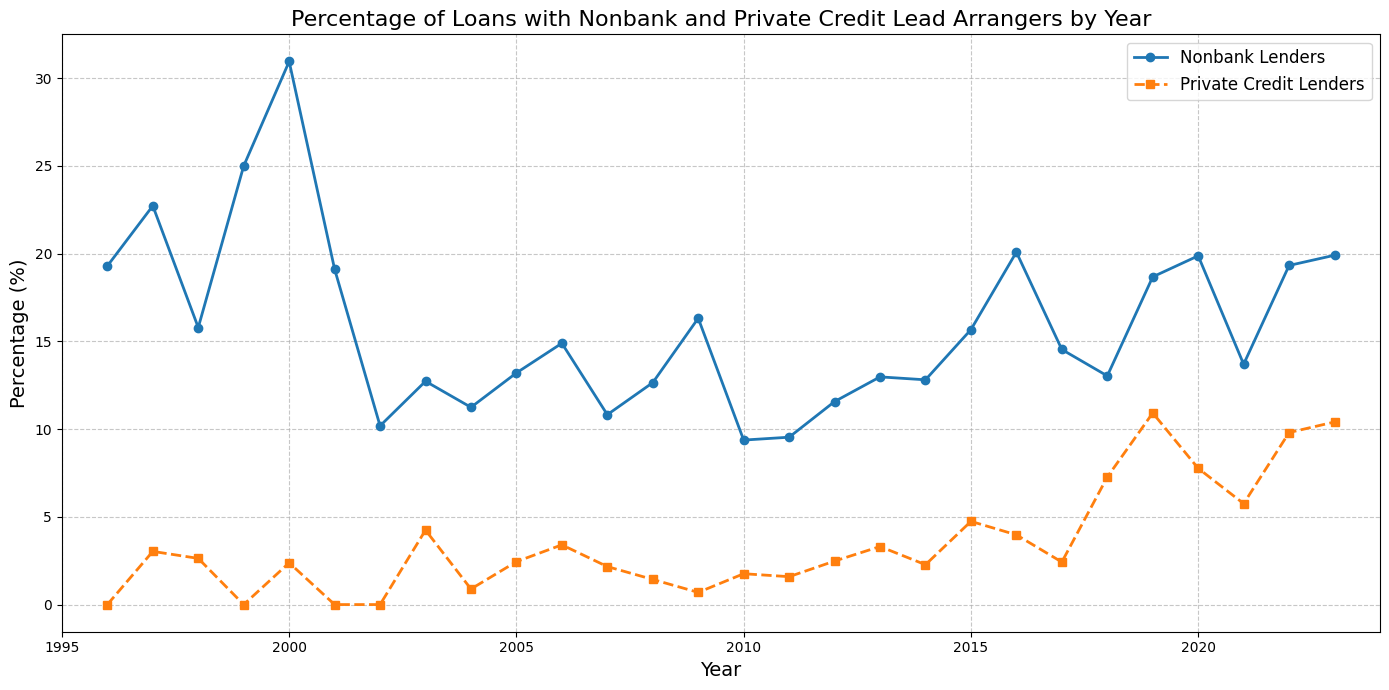

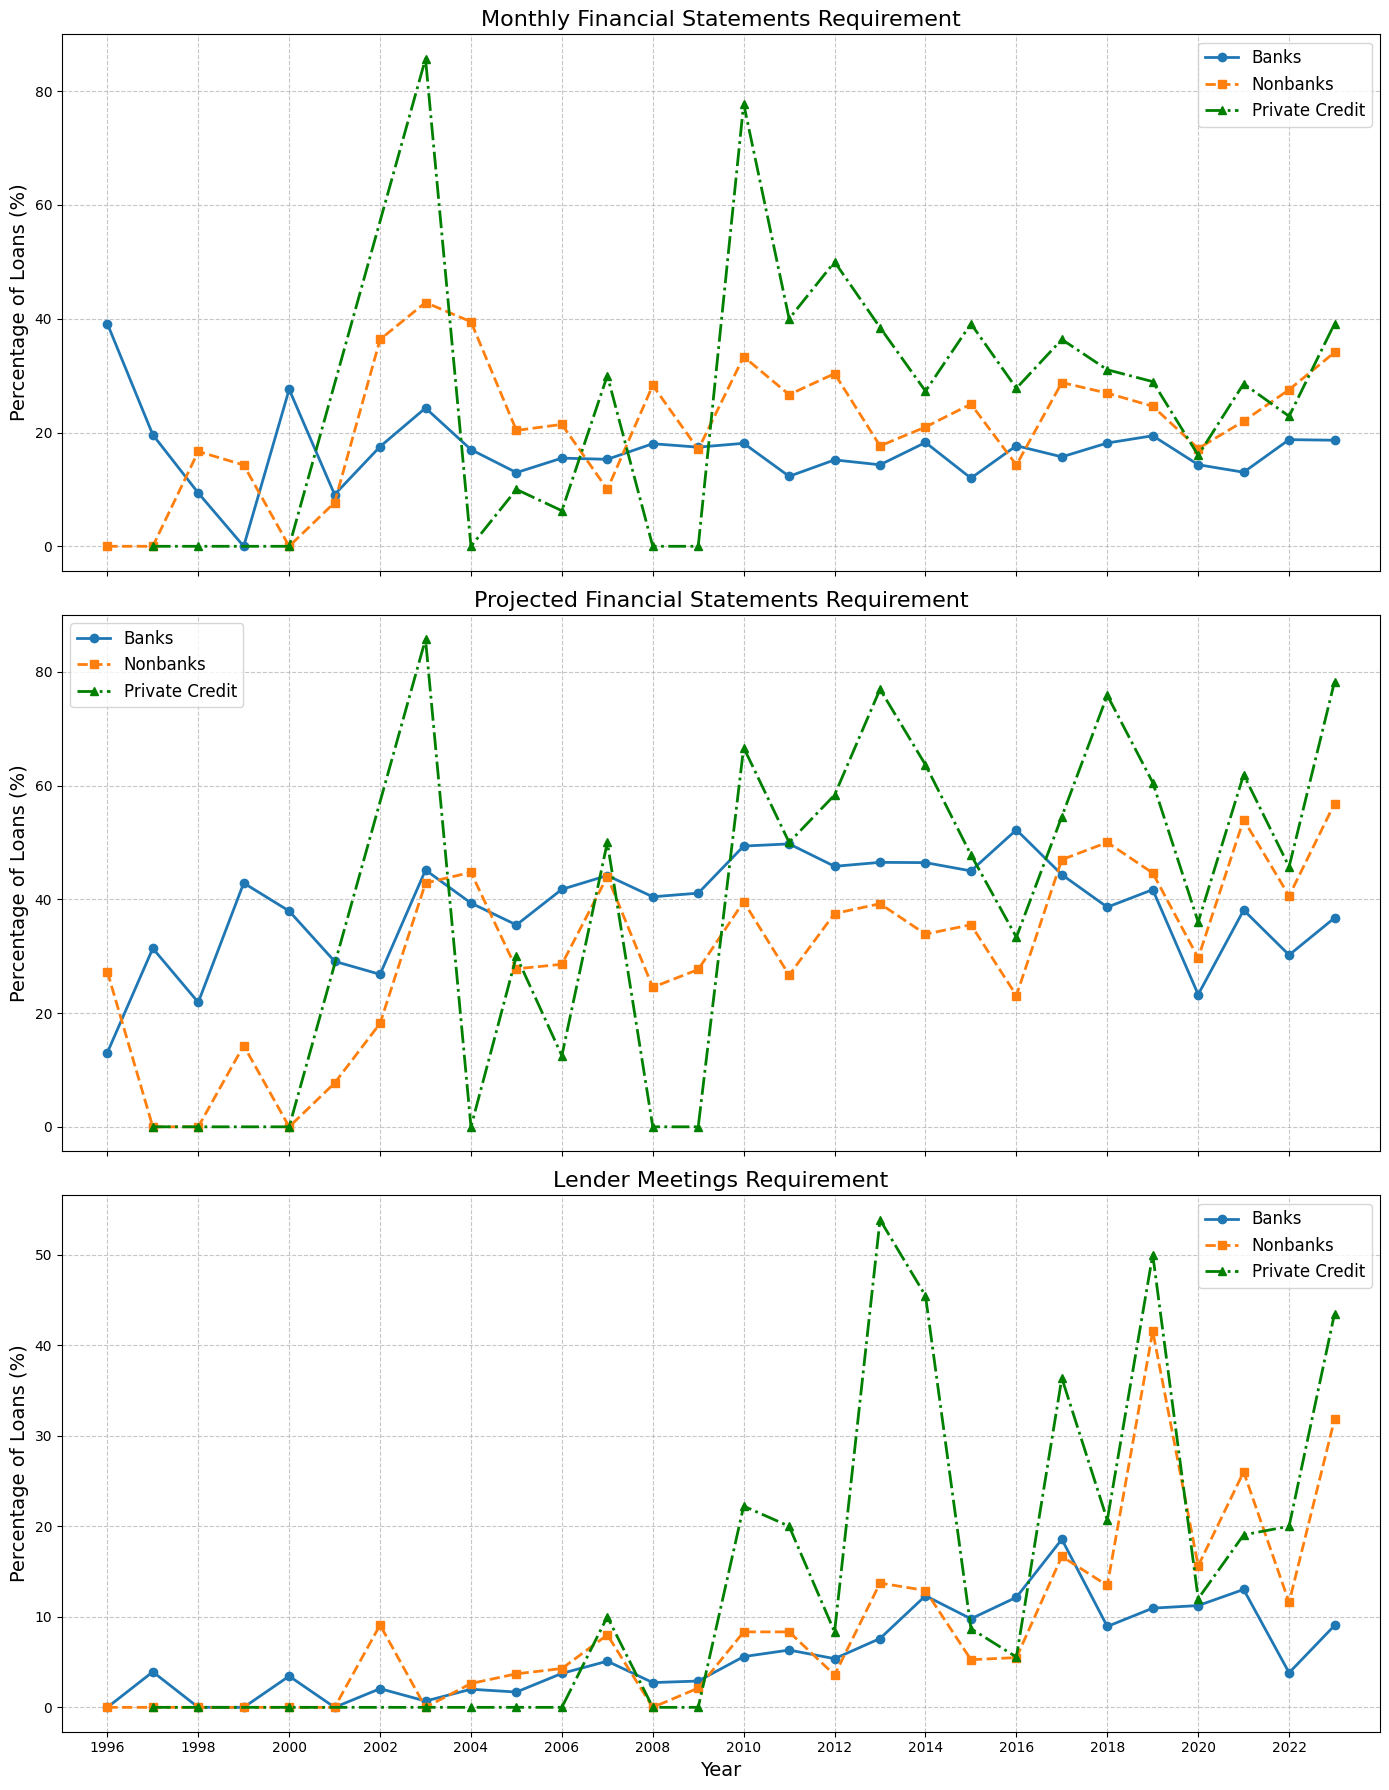

In [158]:
plot_lender_type_trends(merged_data)
plot_covenant_requirements_by_lender_type(merged_data)

In [159]:
# Filter the data to include only loans from 2010 onwards
merged_data = merged_data[merged_data['year'] >= 2010].copy()

# keep if last_year_revenue is between 10 and 1000
merged_data = merged_data[(merged_data['last_year_revenue'] >= 10) & (merged_data['last_year_revenue'] <= 1000)]

(<Figure size 1400x1800 with 3 Axes>,
     Year  Bank Loans  Nonbank Loans  Private Credit Loans  \
 0   2010         224             31                     8   
 1   2011         252             38                     9   
 2   2012         200             42                    11   
 3   2013         162             22                    10   
 4   2014         220             50                     7   
 5   2015         197             43                    18   
 6   2016         186             49                    15   
 7   2017         197             43                    11   
 8   2018         160             33                    21   
 9   2019         119             45                    33   
 10  2020          81             40                    18   
 11  2021         134             28                    15   
 12  2022          93             52                    29   
 13  2023          58             30                    16   
 
     Bank Monthly FS (%)  Nonb

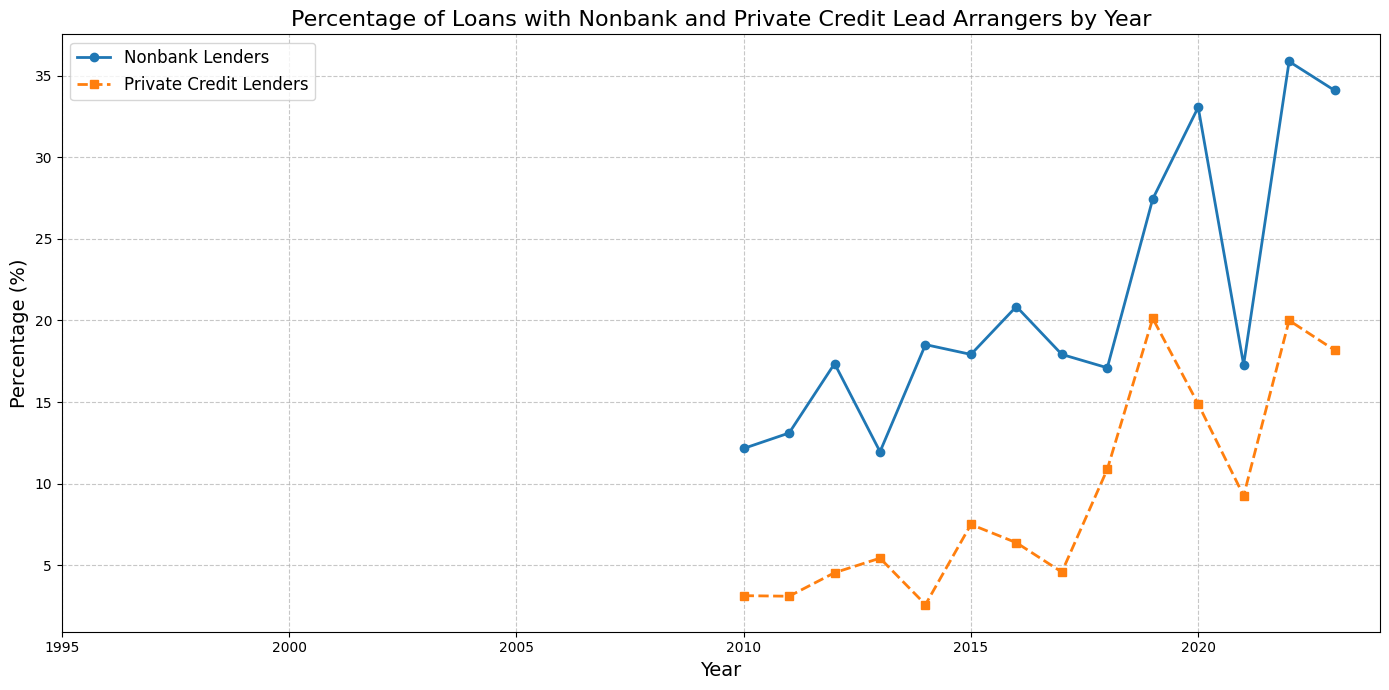

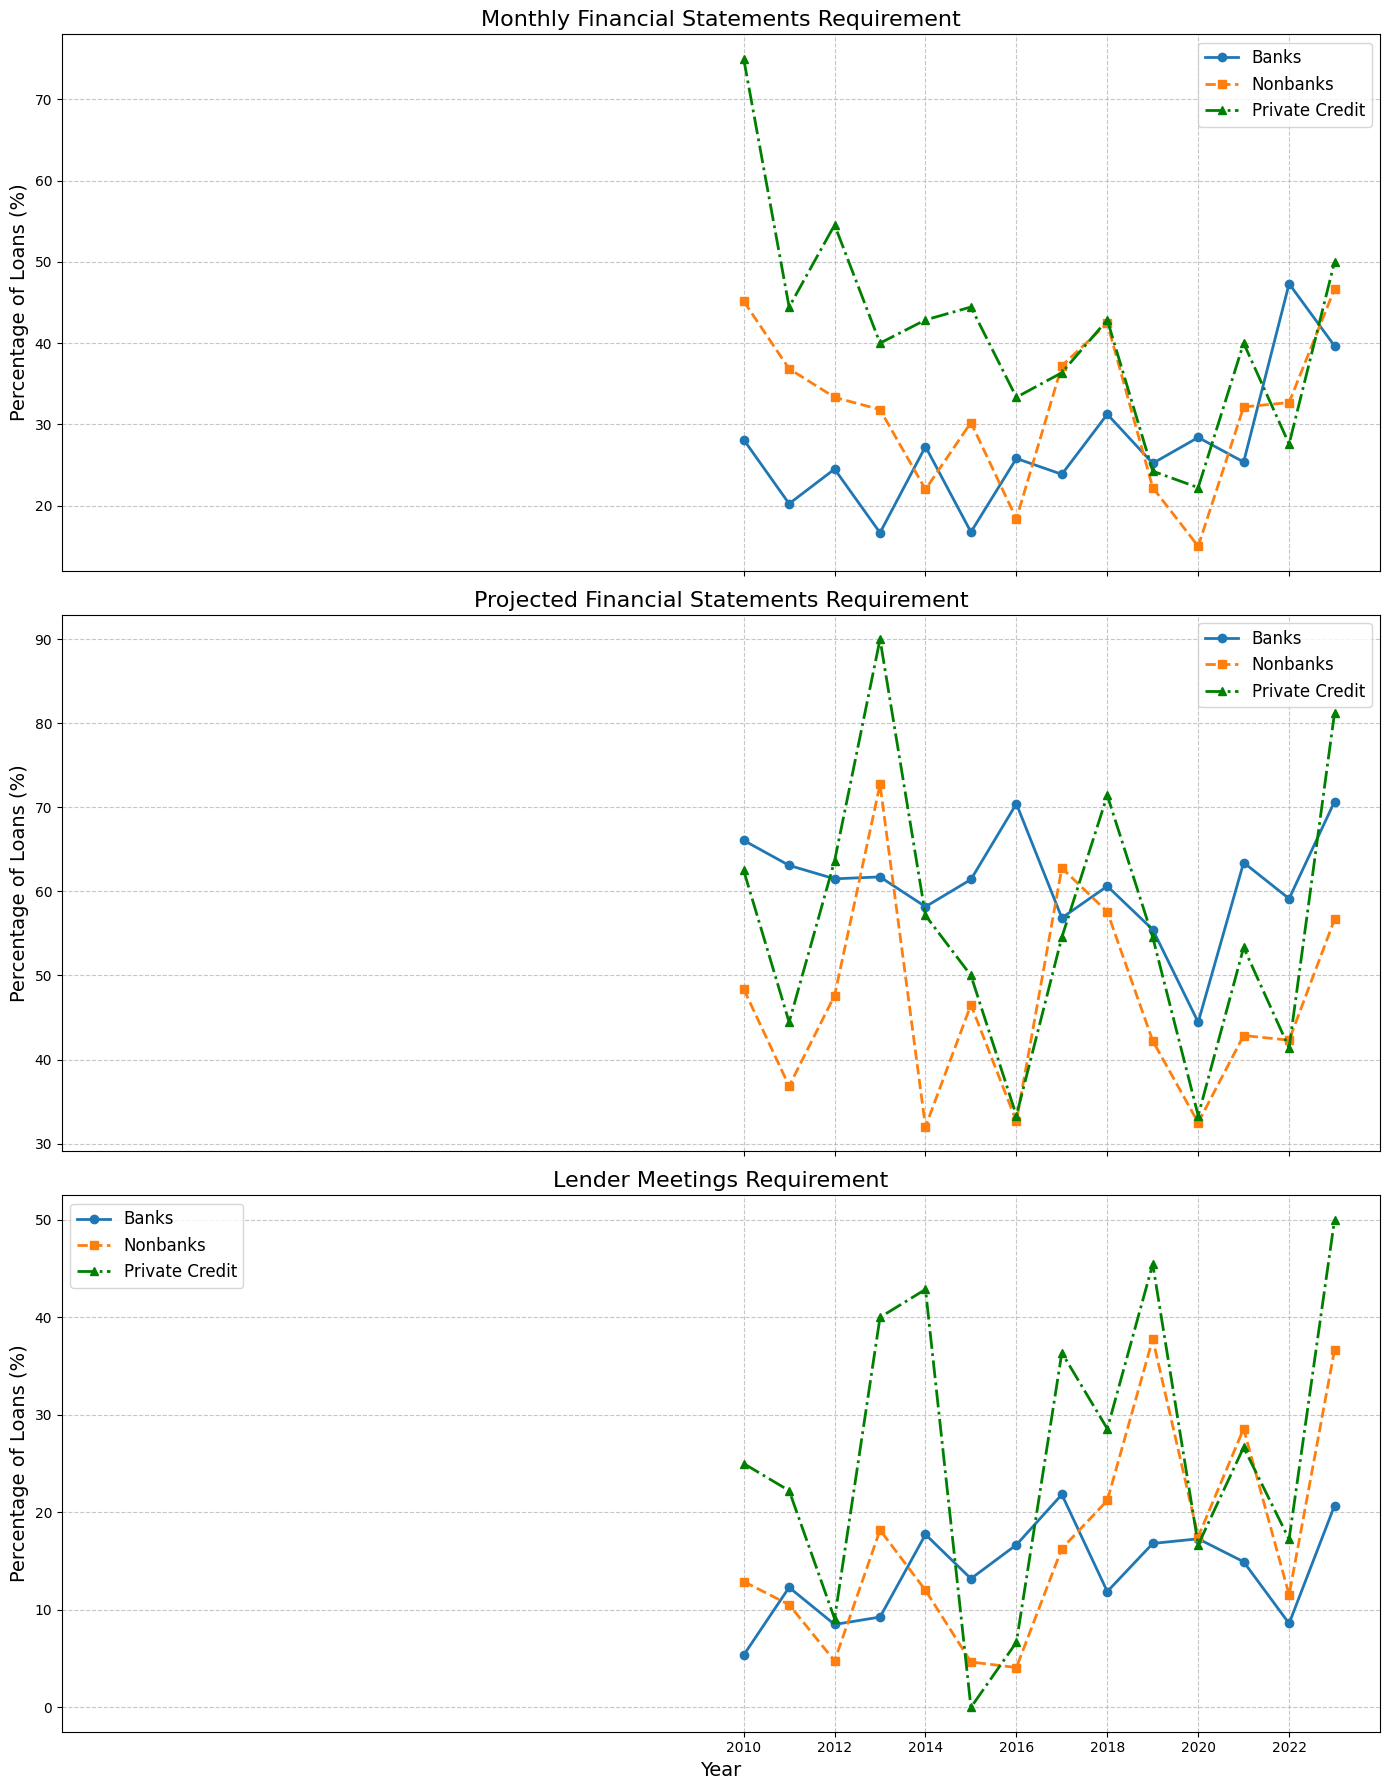

In [160]:
plot_lender_type_trends(merged_data)
plot_covenant_requirements_by_lender_type(merged_data)

In [163]:
# keep if nonbank_lender is 1
nonbank_lender_checks = merged_data[merged_data['nonbank_lender'] == 1]

# keep lead_arranger, standardized_lead_arranger, and nonbank_lender, and private_credit_lender
nonbank_lender_checks = nonbank_lender_checks[['lead_arranger', 'standardized_lead_arranger', 'nonbank_lender', 'private_credit_lender', 'monthly_fs', 'projected_fs', 'lender_meeting']].copy()